In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Using TensorFlow backend.


In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(15,10)

# load data

In [3]:
data=pd.read_excel('/Users/azharul_karim/jupyter notebooks/some_data_file.xlsx')
data.head(5)

,ObjectPropertyID,Index,TimestampGMT,LogTimeGMT,Value,StatusID
0,2732599,0,2016-01-01 00:00:00,2016-01-01 02:28:04.070,139.520007,0
1,2732599,0,2016-01-01 00:05:00,2016-01-01 02:28:04.070,148.066666,0
2,2732599,0,2016-01-01 00:10:00,2016-01-01 02:28:04.070,148.866669,0
3,2732599,0,2016-01-01 00:15:00,2016-01-01 02:28:04.070,132.453326,0
4,2732599,0,2016-01-01 00:20:00,2016-01-01 02:28:04.070,139.933334,0


# Create datetime range to see if any values are missing

In [5]:
from datetime import datetime, timedelta
def datetime_range(start,end,delta):
    current=start
    while current < end:
        yield current
        current += delta

In [6]:
data=data[['TimestampGMT','Value']]
data.columns=[['date','value']]
data['date']=pd.to_datetime(data['date'])

In [7]:
dts=[dt.strftime('%Y-%m-%d %H:%M:%S') for dt in datetime_range(data['date'][0],data['date'][len(data)-1],timedelta(minutes=5))]

In [8]:
len(dts)

104337

In [9]:
len(data)

102326

In [10]:
dts=pd.to_datetime(dts)
dts=pd.DataFrame(dts)
dts.columns=[['date']]

In [11]:
dts.head(5)

,date
0,2016-01-01 00:00:00
1,2016-01-01 00:05:00
2,2016-01-01 00:10:00
3,2016-01-01 00:15:00
4,2016-01-01 00:20:00


In [12]:
data.head(5)

,date,value
0,2016-01-01 00:00:00,139.520007
1,2016-01-01 00:05:00,148.066666
2,2016-01-01 00:10:00,148.866669
3,2016-01-01 00:15:00,132.453326
4,2016-01-01 00:20:00,139.933334


In [13]:
df=pd.merge(dts,data,on='date',how='outer')

In [14]:
df['value'][:10]=df['value'][:10].ffill()
df.head(20)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,date,value
0,2016-01-01 00:00:00,139.520007
1,2016-01-01 00:05:00,148.066666
2,2016-01-01 00:10:00,148.866669
3,2016-01-01 00:15:00,132.453326
4,2016-01-01 00:20:00,139.933334
5,2016-01-01 00:25:00,144.533340
6,2016-01-01 00:30:00,132.346662
7,2016-01-01 00:35:00,146.133331
8,2016-01-01 00:40:00,142.733337
9,2016-01-01 00:45:00,137.333328


In [15]:
df.isnull().sum()

date        0
value    2012
dtype: int64

In [16]:
df['original']=df['value']

In [17]:
idx=df['value'].index[df['value'].apply(np.isnan)]

In [18]:
idx

Int64Index([  1161,   1173,   1179,   5014,   8647,   8648,   8649,   8650,
              8651,   8652,
            ...
            103252, 103496, 103497, 104111, 104137, 104138, 104209, 104210,
            104289, 104290],
           dtype='int64', length=2012)

In [19]:
from itertools import groupby
from operator import itemgetter
gap=[[idx[0]]]
for k, g in groupby(enumerate(idx[1:]), lambda (i, x): i-x):
    gap.append(map(itemgetter(1), g))

In [35]:
gap[440:450]

[[76976],
 [77140],
 [77427],
 [77570],
 [77857],
 [78144],
 [78431],
 [78718],
 [78861],
 [79148]]

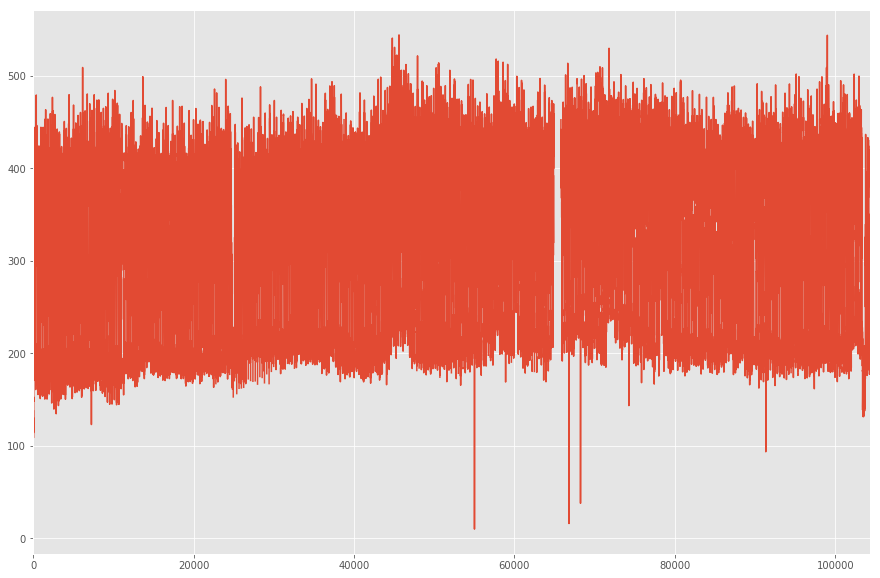

In [25]:
df['original'].plot()
#plt.xlim(0,15000)
plt.show()

# Normalize data

In [26]:
dmax=df['original'].max()
df['value']=df['value']/dmax

## predicting

In [36]:
import time
start=time.time()
model=Sequential()
model.add(LSTM(256,input_shape=(1,1),return_sequences=False))
model.add(Dense(1))
model.add(Activation('relu'))
model.compile(loss='mse',optimizer='adagrad',metrics=["accuracy"])
batch_size=1
epochs=10
c=idx[0]
for item in gap[:450]:
    if len(item)==1:
        print('len==1')
        i=item[0]
        trainX=df['value'].values[c-2:i-1]
        trainY=df['value'].values[c-1:i]
        #print(len(trainX),len(trainY))
        testX=df['value'].values[i-1]
        trainX=np.reshape(trainX,(trainX.shape[0],1,1))
        trainY=np.reshape(trainY,(trainY.shape[0],1))
        testX=np.reshape(testX,(1,1,1))
        #print(trainX.shape,testX.shape,trainY.shape)
        batch_size=2
        if len(trainX)<100:
            batch_size=2
        elif 100<=len(trainX)<=1000:
            batch_size=10
        else:
            batch_size=100
        model.fit(trainX,trainY,epochs=epochs,batch_size=batch_size,verbose=0)
        temp=model.predict(testX)
        df['value'][i]=temp[0][0]
        c=i
        print(i)
        print(temp[0][0])
    elif 1<len(item)<=10:
        print('1<len<10')
        for j in item:
            trainX=df['value'].values[c-2:j-1]
            trainY=df['value'].values[c-1:j]
            testX=df['value'].values[j-1]
            trainX=np.reshape(trainX,(trainX.shape[0],1,1))
            trainY=np.reshape(trainY,(trainY.shape[0],1))
            testX=np.reshape(testX,(1,1,1))
            #print(trainX.shape,testX.shape,trainY.shape)
            batch_size=2
            if len(trainX)<100:
                batch_size=2
            elif 100<=len(trainX)<=1000:
                batch_size=10
            else:
                batch_size=100
            model.fit(trainX,trainY,epochs=epochs,batch_size=batch_size,verbose=0)
            temp=model.predict(testX)
            df['value'][j]=temp[0][0]
            c=j
            print(j)
            print(temp[0][0])
    else:
        print('len >10')
        k=item[0]
        n=len(item)
        model2=Sequential()
        model2.add(LSTM(256,input_shape=(1,1),return_sequences=True))
        model2.add(Dropout(0.5))
        model2.add(LSTM(128,input_shape=(1,1),return_sequences=False))
        #model2.add(Activation('sigmoid'))
        model2.add(Dropout(0.5))
        #model.add(LSTM(2))
        #model.add(LSTM(2))
        model2.add(Dense(1))
        model2.add(Activation('relu'))
        model2.compile(loss='mse',optimizer='adagrad',metrics=["accuracy"])
        batch_size=2
        epochs=10
        trainX=df['value'].values[:k-n]
        trainY=df['value'].values[n:k]
        testX=df['value'].values[k-n:k]
        if len(trainX)<100:
            batch_size=2
        elif 100<=len(trainX)<=1000:
            batch_size=10
        else:
            batch_size=100
        trainX=np.reshape(trainX,(trainX.shape[0],1,1))
        trainY=np.reshape(trainY,(trainY.shape[0],1))
        testX=np.reshape(testX,(testX.shape[0],1,1))
        model2.fit(trainX,trainY,epochs=epochs,batch_size=batch_size,verbose=0)
        temp=model2.predict(testX)
        print(type(temp))
        print(temp)
        for p in xrange(n):
            df['value'][k+p]=temp[p][0]
            
        
end=time.time()


len==1


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1161
0.311713
len==1
1173
0.325734
len==1
1179
0.317603
len==1
5014
0.697271
len >10
<type 'numpy.ndarray'>


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[[ 0.360755  ]
 [ 0.36779237]
 [ 0.35270095]
 [ 0.3757998 ]
 [ 0.35912195]
 [ 0.37328765]
 [ 0.35383558]
 [ 0.34283566]
 [ 0.34446067]
 [ 0.34903151]
 [ 0.32939336]
 [ 0.34417263]]
len >10
<type 'numpy.ndarray'>
[[ 0.56422627]
 [ 0.58378798]
 [ 0.57218456]
 [ 0.56996483]
 [ 0.55564243]
 [ 0.54812133]
 [ 0.56496507]
 [ 0.57571107]
 [ 0.58300692]
 [ 0.56236047]
 [ 0.5740546 ]
 [ 0.58495981]
 [ 0.56158322]
 [ 0.56564564]
 [ 0.5761984 ]
 [ 0.56624848]
 [ 0.56449848]
 [ 0.55063981]
 [ 0.55585575]
 [ 0.55362517]
 [ 0.55013603]]
len >10
<type 'numpy.ndarray'>
[[ 0.5247767 ]
 [ 0.53851449]
 [ 0.53073567]
 [ 0.52347636]
 [ 0.53903133]
 [ 0.53632981]
 [ 0.52930897]
 [ 0.53592891]
 [ 0.53709275]
 [ 0.54630488]
 [ 0.54283881]
 [ 0.54432124]
 [ 0.54663962]
 [ 0.67819422]
 [ 0.69890594]
 [ 0.70169991]
 [ 0.69888991]
 [ 0.68251771]
 [ 0.69098061]
 [ 0.68618244]
 [ 0.6887579 ]
 [ 0.67920327]
 [ 0.68842202]
 [ 0.68282187]
 [ 0.67617577]
 [ 0.68522251]
 [ 0.67353141]
 [ 0.68312603]
 [ 0.68578249]
 [ 0.6

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


12848
0.651516
12849
0.639229
1<len<10
12992
0.349548
12993
0.354151
1<len<10
13136
0.67828
13137
0.683721
1<len<10
13280
0.348582
13281
0.346852
1<len<10
13424
0.726623
13425
0.731842
1<len<10
13568
0.401548
13569
0.41187
1<len<10
13712
0.736838
13713
0.723498
1<len<10
13856
0.362811
13857
0.359156
1<len<10
14000
0.703565
14001
0.719766
len==1
14145
0.391017
len==1
14289
0.712981
len==1
14433
0.391604
len==1
14577
0.799362
len==1
14721
0.361355
len==1
14865
0.737312
len==1
15009
0.365083
len==1
15153
0.703981
len==1
15297
0.350993
len==1
15441
0.618334
len==1
15585
0.367823
len==1
15729
0.643475
len==1
15873
0.346828
len==1
16017
0.665629
len==1
16161
0.360531
len==1
16305
0.71264
len==1
16449
0.356331
len==1
16593
0.717356
len==1
16737
0.372674
len==1
16881
0.657103
len==1
17025
0.354545
len==1
17169
0.640632
len==1
17313
0.352322
len==1
17457
0.669302
len==1
17601
0.383766
len==1
17745
0.665268
len==1
17889
0.354743
len==1
18033
0.668118
len==1
18177
0.36479
len==1
18321
0.668785
le

45243
0.408413
len==1
45387
0.778436
len==1
45531
0.434302
len==1
45675
0.805763
len==1
45819
0.440558
len==1
45963
0.780069
len==1
46250
0.851078
len==1
46394
0.443056
len==1
46538
0.768566
len==1
46682
0.448078
len==1
46826
0.761507
len==1
46970
0.419783
len==1
47114
0.745978
len==1
47257
0.376189
len==1
47401
0.680945
len==1
47545
0.372119
len==1
47689
0.709183
len==1
47833
0.373421
len==1
47977
0.737397
len==1
48121
0.39616
len==1
48264
0.722856
len==1
48408
0.400677
len==1
48552
0.739186
len==1
48696
0.427569
len==1
48840
0.790879
len==1
48984
0.402555
len==1
49128
0.78301
len==1
49271
0.400047
len==1
49415
0.775813
len==1
49559
0.408122
len==1
49703
0.733291
len==1
49847
0.404588
len==1
49991
0.796734
len==1
50134
0.383898
len==1
50278
0.773277
len==1
50422
0.379059
len==1
50566
0.867637
len==1
50710
0.39246
len==1
50854
0.78828
len==1
50997
0.390324
len==1
51141
0.727153
len==1
51285
0.370598
len==1
51429
0.696023
len==1
51573
0.361506
len==1
51716
0.717875
len==1
51860
0.359162

65800
0.828163
len==1
65944
0.422008
len==1
66231
0.424681
len==1
66375
0.850783
len==1
66662
0.860389
len==1
66949
0.813614
len==1
67093
0.456168
len==1
67380
0.420315
len==1
67667
0.483801
len==1
67811
0.903349
len==1
67954
0.467518
len==1
68098
0.776497
len==1
68385
0.782197
len==1
68529
0.467871
len==1
68672
0.824258
len==1
68816
0.478668
len==1
69103
0.478558
len==1
69390
0.419596
len==1
69534
0.850001
len==1
69677
0.441432
len==1
69821
0.77819
len==1
70108
0.859471
len==1
70395
0.866966
len==1
70682
0.759933
len==1
70826
0.468995
len==1
70969
0.896141
len==1
71113
0.455252
len==1
71256
0.82155
len==1
71400
0.393853
len==1
71687
0.543568
len==1
71974
0.50188
len==1
72261
0.509671
len==1
72548
0.517284
len==1
72835
0.479359
len==1
73122
0.492624
len==1
73266
0.810069
len==1
73409
0.417428
len==1
73553
0.729237
len==1
73696
0.591144
len==1
73840
0.774571
len==1
73983
0.603524
len==1
74127
0.832893
len==1
74414
0.798963
1<len<10
74468
0.8398
74469
0.840761
74470
0.842358
74471
0.8437

In [37]:
print('total runtime=', (end-start)/60)

('total runtime=', 39.86617508331935)


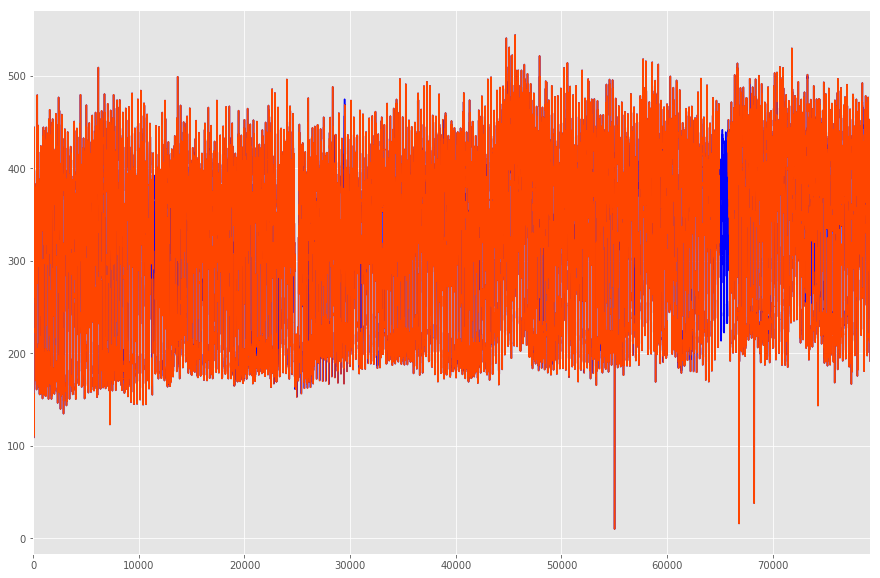

In [38]:
#plt.plot(series.values)
plt.plot(df['value']*dmax,color='blue')
plt.plot(df['original'],color='orangered')
plt.xlim(0,79200)
#plt.ylim(0,0.7)
plt.show()